# Regression

In this notebook, we perform regression analyses to predict if a paper is cited from Wikipedia.

In [216]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random, codecs, json
import pandas as pd
import numpy as np

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, sklearn
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set(style="white")
sns.set_context("paper", font_scale=1.2, rc={"lines.linewidth": 2.5})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [217]:
# load data

df_meta = pd.read_csv("../cwts_covid/datasets_output/df_pub.csv",compression="gzip")
df_joined_all = pd.read_csv("data/df_joined_all.csv", compression="gzip")

In [218]:
df_meta.head()

pub_id                                              title  \
0       0  ‘A ticking time bomb’: Scientists worry about ...   
1       1  [Ten hot issues of breast cancer under the nov...   
2       2  Another Piece of the Puzzle: Human Metapneumov...   
3       3  Viral etiology of severe pneumonia among Kenya...   
4       4  Critically Ill Patients With Influenza A(H1N1)...   

                                            abstract  publication_year  \
0  CAPE TOWN, SOUTH AFRICA—Late on Sunday evening...            2020.0   
1                                                NaN            2020.0   
2  BACKGROUND: Each winter respiratory viruses ac...            2008.0   
3  CONTEXT: Pneumonia is the leading cause of chi...            2010.0   
4                                                NaN            2014.0   

   publication_month                        journal volume issue pages  \
0                NaN                        Science    NaN   NaN   NaN   
1                2.0        Chinese medical journal    100     0  e002   
2               12.0  Archives of Internal Medicine    NaN   NaN   NaN   
3                5.0                           JAMA    NaN   NaN   NaN   
4                4.0                           JAMA    NaN   NaN   NaN   

                                      doi        pmid       pmcid  \
0                  0.1126/science.abb7331         NaN         NaN   
1  10.0376/cma.j.issn.0376-2491.2020.0002  32036640.0         NaN   
2            10.1001/archinte.168.22.2489  19064834.0  pmc2783624   
3                   10.1001/jama.2010.675  20501927.0  pmc2968755   
4                  10.1001/jama.2014.2116  24566924.0  pmc6689404   

    dimensions_id                   timestamp  
0             NaN  2020-04-25 09:08:51.611715  
1  pub.1124777091  2020-04-25 09:08:51.611715  
2             NaN  2020-04-25 09:08:51.611715  
3             NaN  2020-04-25 09:08:51.611715  
4             NaN  2020-04-25 09:08:51.611715

In [219]:
df_meta.columns

Index(['pub_id', 'title', 'abstract', 'publication_year', 'publication_month',
       'journal', 'volume', 'issue', 'pages', 'doi', 'pmid', 'pmcid',
       'dimensions_id', 'timestamp'],
      dtype='object')

In [220]:
df_meta.shape

(69969, 14)

In [221]:
df_joined_all.head()

pub_id                                              title  \
0       1  [Ten hot issues of breast cancer under the nov...   
1       2  Another Piece of the Puzzle: Human Metapneumov...   
2       3  Viral etiology of severe pneumonia among Kenya...   
3       4  Critically Ill Patients With Influenza A(H1N1)...   
4       5  Prevalence of Depression, Depressive Symptoms,...   

                                            abstract  publication_year  \
0                                                NaN            2020.0   
1  BACKGROUND: Each winter respiratory viruses ac...            2008.0   
2  CONTEXT: Pneumonia is the leading cause of chi...            2010.0   
3                                                NaN            2014.0   
4  IMPORTANCE: Medical students are at high risk ...            2016.0   

   publication_month                        journal volume issue pages  \
0                2.0        Chinese medical journal    100     0  e002   
1               12.0  Archives of Internal Medicine    NaN   NaN   NaN   
2                5.0                           JAMA    NaN   NaN   NaN   
3                4.0                           JAMA    NaN   NaN   NaN   
4               12.0                           JAMA    NaN   NaN   NaN   

                                      doi  ...  counts_twitter  \
0  10.0376/cma.j.issn.0376-2491.2020.0002  ...             1.0   
1            10.1001/archinte.168.22.2489  ...             0.0   
2                   10.1001/jama.2010.675  ...             0.0   
3                  10.1001/jama.2014.2116  ...           100.0   
4                 10.1001/jama.2016.17324  ...          2439.0   

  counts_twitter_unique counts_total altmetric_score member_of_the_public  \
0                   1.0          1.0           0.250                  1.0   
1                   0.0          1.0           3.000                  0.0   
2                   0.0          2.0          10.120                  0.0   
3                  85.0        103.0          57.600                 63.0   
4                1813.0       2696.0        2064.628               1198.0   

  researcher practitioner  science_communicator  in_wikipedia posted_on_year  
0        0.0          0.0                   0.0         False            NaN  
1        0.0          0.0                   0.0          True         2017.0  
2        0.0          0.0                   0.0         False            NaN  
3        3.0         17.0                   2.0         False            NaN  
4      216.0        358.0                  35.0          True         2016.0  

[5 rows x 42 columns]

In [222]:
df_joined_all.columns

Index(['pub_id', 'title', 'abstract', 'publication_year', 'publication_month',
       'journal', 'volume', 'issue', 'pages', 'doi', 'pmid', 'pmcid', 'lang',
       'dimensions_id', 'publication_date', 'publication_type', 'issn',
       'times_cited', 'relative_citation_ratio', 'for_top', 'for_bottom',
       'scite_total', 'scite_supporting', 'scite_contradicting',
       'scite_mentioning', 'altmetric_id', 'counts_mendeley', 'counts_news',
       'counts_blogs', 'counts_facebook', 'counts_policy', 'counts_wikipedia',
       'counts_twitter', 'counts_twitter_unique', 'counts_total',
       'altmetric_score', 'member_of_the_public', 'researcher', 'practitioner',
       'science_communicator', 'in_wikipedia', 'posted_on_year'],
      dtype='object')

In [223]:
df_joined_all.shape

(64040, 42)

In [224]:
# load features

# you can select here if to use an LDA or a CTM topic model
df_topic_intensity = pd.read_csv("data/df_topic_intensity.csv", compression="gzip")
#df_topic_intensity = pd.read_csv("data/df_topic_intensity_ctm.csv", compression="gzip")
df_specter = pd.read_csv("data/df_spectre.csv", compression="gzip")
df_network = pd.read_csv("data/df_network.csv", compression="gzip")

In [225]:
df_topic_intensity.columns

Index(['tm_coronaviruses', 'tm_transmission', 'tm_phe', 'tm_molecular_biology',
       'tm_respiratory_diseases', 'tm_immunology', 'tm_clinical_medicine',
       'pub_id'],
      dtype='object')

In [226]:
df_topic_intensity.shape

(66915, 8)

In [227]:
df_specter.columns

Index(['pub_id', 'spectre_cluster_id', 'spectre_cluster_size',
       'spectre_semantic_centrality'],
      dtype='object')

In [228]:
df_specter.shape

(66762, 4)

In [229]:
df_network.columns

Index(['dimensions_id', 'network_cluster_id',
       'network_cluster_above_threshold', 'network_cluster_size',
       'network_global_degree', 'network_global_pagerank',
       'network_local_degree', 'network_local_pagerank'],
      dtype='object')

In [230]:
df_network.shape

(53131, 8)

In [231]:
### Create feature data frame

In [232]:
df_features = df_joined_all[['pub_id', 'publication_year', 'publication_month',
       'journal', 'dimensions_id', 'times_cited', 'relative_citation_ratio',
       'scite_total', 'scite_supporting', 'scite_contradicting',
       'scite_mentioning', 'counts_mendeley',
       'counts_news', 'counts_blogs', 'counts_facebook', 'counts_policy',
       'counts_wikipedia', 'counts_twitter', 'counts_twitter_unique',
       'counts_total', 'altmetric_score', 'member_of_the_public', 'researcher',
       'practitioner', 'science_communicator', 'in_wikipedia', 'posted_on_year']].merge(df_topic_intensity, how="left", left_on="pub_id", right_on="pub_id")
df_features = df_features.merge(df_specter, how="left", left_on="pub_id", right_on="pub_id")
df_features = df_features.merge(df_network, how="left", left_on="dimensions_id", right_on="dimensions_id")

In [233]:
df_features.shape

(64040, 44)

In [234]:
df_features.columns

Index(['pub_id', 'publication_year', 'publication_month', 'journal',
       'dimensions_id', 'times_cited', 'relative_citation_ratio',
       'scite_total', 'scite_supporting', 'scite_contradicting',
       'scite_mentioning', 'counts_mendeley', 'counts_news', 'counts_blogs',
       'counts_facebook', 'counts_policy', 'counts_wikipedia',
       'counts_twitter', 'counts_twitter_unique', 'counts_total',
       'altmetric_score', 'member_of_the_public', 'researcher', 'practitioner',
       'science_communicator', 'in_wikipedia', 'posted_on_year',
       'tm_coronaviruses', 'tm_transmission', 'tm_phe', 'tm_molecular_biology',
       'tm_respiratory_diseases', 'tm_immunology', 'tm_clinical_medicine',
       'spectre_cluster_id', 'spectre_cluster_size',
       'spectre_semantic_centrality', 'network_cluster_id',
       'network_cluster_above_threshold', 'network_cluster_size',
       'network_global_degree', 'network_global_pagerank',
       'network_local_degree', 'network_local_pagerank']

In [235]:
# Profiling

In [236]:
from pandas_profiling import ProfileReport
which_columns = ['publication_year', 'publication_month', 'posted_on_year', 'journal',
       'times_cited', 'relative_citation_ratio',
       'scite_total', 'scite_supporting', 'scite_contradicting',
       'scite_mentioning', 'counts_mendeley', 'counts_news', 'counts_blogs',
       'counts_facebook', 'counts_policy', 'counts_wikipedia',
       'counts_twitter', 'counts_twitter_unique', 'counts_total',
       'altmetric_score', 'member_of_the_public', 'researcher', 'practitioner',
       'science_communicator', 'in_wikipedia', 'tm_coronaviruses', 'tm_transmission', 'tm_phe', 'tm_molecular_biology',
       'tm_respiratory_diseases', 'tm_immunology', 'tm_clinical_medicine', 'spectre_cluster_id', 'spectre_cluster_size',
       'spectre_semantic_centrality', 'network_cluster_id',
       'network_cluster_above_threshold', 'network_cluster_size',
       'network_global_degree', 'network_global_pagerank',
       'network_local_degree', 'network_local_pagerank']

In [237]:
profile = ProfileReport(df_features[which_columns], title='Pandas Profiling Report', html={'style':{'full_width':True}})

In [238]:
profile.to_widgets()

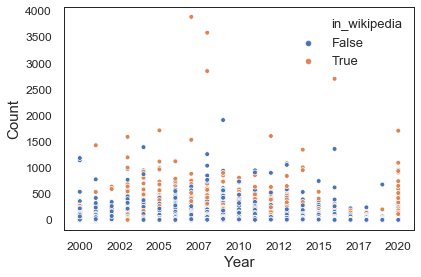

In [74]:
# scatter of citations vs time of publication

since_when = 1999

sns.scatterplot(x='publication_year',y='times_cited', hue='in_wikipedia', data=df_joined_all[df_joined_all.publication_year>since_when])
plt.xlabel("Year", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.tick_params(labelsize=12)
plt.legend(fontsize=13)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.tight_layout()
plt.savefig("figures/nb5_dim_citations_year_wiki.pdf")

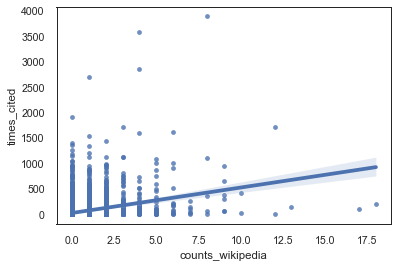

In [349]:
sns.regplot(x='counts_wikipedia', y='times_cited', data=df_joined_all[df_joined_all.publication_year>since_when])

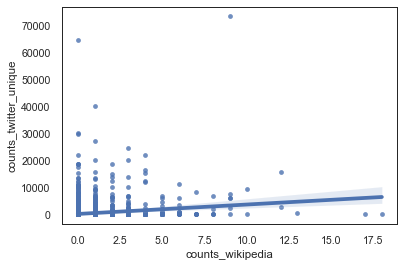

In [350]:
sns.regplot(x='counts_wikipedia', y='counts_twitter_unique', data=df_joined_all[df_joined_all.publication_year>since_when])

### Regressions

In [239]:
which_columns

['publication_year',
 'publication_month',
 'posted_on_year',
 'journal',
 'times_cited',
 'relative_citation_ratio',
 'scite_total',
 'scite_supporting',
 'scite_contradicting',
 'scite_mentioning',
 'counts_mendeley',
 'counts_news',
 'counts_blogs',
 'counts_facebook',
 'counts_policy',
 'counts_wikipedia',
 'counts_twitter',
 'counts_twitter_unique',
 'counts_total',
 'altmetric_score',
 'member_of_the_public',
 'researcher',
 'practitioner',
 'science_communicator',
 'in_wikipedia',
 'tm_coronaviruses',
 'tm_transmission',
 'tm_phe',
 'tm_molecular_biology',
 'tm_respiratory_diseases',
 'tm_immunology',
 'tm_clinical_medicine',
 'spectre_cluster_id',
 'spectre_cluster_size',
 'spectre_semantic_centrality',
 'network_cluster_id',
 'network_cluster_above_threshold',
 'network_cluster_size',
 'network_global_degree',
 'network_global_pagerank',
 'network_local_degree',
 'network_local_pagerank']

In [240]:
def to_log(n):
    if not n:
        n=0
    return np.log(n+1)

In [241]:
# add default values of zeros

In [242]:
df_reg = df_features[which_columns]
df_reg['in_wikipedia'] = df_reg['in_wikipedia'].astype(int)
#df_reg['publication_year'] = df_reg['publication_year'].astype(int)
#df_reg['publication_month'] = df_reg['publication_month'].astype(int)
#df_reg['relative_citation_ratio'] = df_reg['relative_citation_ratio']#.apply(to_log)
df_reg['counts_wikipedia'] = df_reg['counts_wikipedia'].apply(to_log)
df_reg['counts_blogs_news'] = (df_reg['counts_blogs']+df_reg['counts_news']).apply(to_log)
df_reg['counts_mendeley'] = df_reg['counts_mendeley'].apply(to_log)
#df_reg['counts_news'] = df_reg['counts_news'].apply(to_log)
df_reg['counts_policy'] = df_reg['counts_policy'].apply(to_log)
df_reg['counts_facebook'] = df_reg['counts_facebook'].apply(to_log)
df_reg['counts_twitter_unique'] = df_reg['counts_twitter_unique'].apply(to_log)
df_reg['supporting_ratio'] = df_reg['scite_supporting']/df_reg['scite_total']
df_reg['contradicting_ratio'] = df_reg['scite_contradicting']/df_reg['scite_total']
df_reg['researcher_ratio'] = df_reg['researcher']/(df_reg['researcher']+df_reg['member_of_the_public'])
df_reg['science_communicator_ratio'] = df_reg['science_communicator']/(df_reg['science_communicator']+df_reg['member_of_the_public'])
df_reg['expert_ratio'] = (df_reg['researcher']+df_reg['practitioner']+df_reg['science_communicator'])/(df_reg['researcher']+df_reg['practitioner']+df_reg['science_communicator']+df_reg['member_of_the_public'])
df_reg['times_cited'] = df_reg['times_cited'].apply(to_log)
df_reg['spectre_cluster_size'] = df_reg['spectre_cluster_size'].apply(to_log)
df_reg['network_cluster_size'] = df_reg['network_cluster_size'].apply(to_log)
df_reg['network_local_degree'] = df_reg['network_local_degree'].apply(to_log)
df_reg['network_global_degree'] = df_reg['network_global_degree'].apply(to_log)
df_reg['network_global_pagerank'] = df_reg['network_global_pagerank']/df_reg['network_global_pagerank'].max()
df_reg['network_local_pagerank'] = df_reg['network_local_pagerank']/df_reg['network_local_pagerank'].max()

In [243]:
regr_columns = [
 'times_cited',
 'relative_citation_ratio',
 'scite_supporting',
 'scite_contradicting',
 'scite_mentioning',
 'counts_mendeley',
 'counts_blogs_news',
 #'counts_blogs',
 'counts_facebook',
 'counts_policy',
 'counts_wikipedia',
 'counts_twitter',
 'counts_twitter_unique',
 'counts_total',
 'altmetric_score',
 'member_of_the_public',
 'researcher',
 'practitioner',
 'science_communicator',
 'supporting_ratio',
 'contradicting_ratio',
 'researcher_ratio',
 'science_communicator_ratio',
 'expert_ratio',
 'spectre_cluster_size',
 'spectre_semantic_centrality',
 'network_cluster_size',
 'network_local_degree',
 'network_global_degree',
 'network_local_pagerank',
 'network_global_pagerank']

df_reg[regr_columns] = df_reg[regr_columns].fillna(0)
df_reg['network_cluster_above_threshold'] = df_reg['network_cluster_above_threshold'].fillna(False)

In [244]:
df_reg[df_reg['expert_ratio']>0].shape

(18445, 48)

In [245]:
df_reg.tail()

publication_year  publication_month  posted_on_year journal  \
64035            1998.0                7.0             NaN     NaN   
64036            1976.0               10.0             NaN     NaN   
64037            1998.0                7.0             NaN     NaN   
64038            1998.0               10.0             NaN     NaN   
64039            1998.0               10.0             NaN     NaN   

       times_cited  relative_citation_ratio  scite_total  scite_supporting  \
64035     1.609438                     0.18          NaN               0.0   
64036     4.718499                     0.00          NaN               0.0   
64037     2.197225                     1.31          NaN               0.0   
64038     3.367296                     2.16          NaN               0.0   
64039     2.484907                     0.35          NaN               0.0   

       scite_contradicting  scite_mentioning  ...  network_global_degree  \
64035                  0.0               0.0  ...               5.752573   
64036                  0.0               0.0  ...               3.135494   
64037                  0.0               0.0  ...               2.995732   
64038                  0.0               0.0  ...               4.488636   
64039                  0.0               0.0  ...               3.465736   

       network_global_pagerank  network_local_degree  network_local_pagerank  \
64035                 0.072569                   0.0                     0.0   
64036                 0.053443                   0.0                     0.0   
64037                 0.040701                   0.0                     0.0   
64038                 0.068620                   0.0                     0.0   
64039                 0.043940                   0.0                     0.0   

       counts_blogs_news  supporting_ratio  contradicting_ratio  \
64035                0.0               0.0                  0.0   
64036                0.0               0.0                  0.0   
64037                0.0               0.0                  0.0   
64038                0.0               0.0                  0.0   
64039                0.0               0.0                  0.0   

       researcher_ratio  science_communicator_ratio  expert_ratio  
64035               0.0                         0.0           0.0  
64036               0.0                         0.0           0.0  
64037               0.0                         0.0           0.0  
64038               0.0                         0.0           0.0  
64039               0.0                         0.0           0.0  

[5 rows x 48 columns]

In [246]:
## CHECK here distributions to make sure no outliers!!

In [247]:
top_journals = df_reg.journal.value_counts()[:20].index
def top_journal(j):
    if j in top_journals:
        return "_".join(j.split())
    return "OTHER"

df_reg["top_j"] = df_reg.journal.apply(top_journal)

In [248]:
df_reg["top_j"].value_counts()

OTHER                             49716
Journal_of_Virology                1761
medRxiv                            1567
PLoS_One                           1559
SSRN_Electronic_Journal            1047
Virology                            937
Emerg_Infect_Dis                    737
The_Lancet                          689
Viruses                             588
Virus_Research                      533
Vaccine                             516
Arch_Virol                          501
Journal_of_Clinical_Virology        489
Sci_Rep                             480
Veterinary_Microbiology             466
bioRxiv                             447
Research_Square                     436
Journal_of_Virological_Methods      424
The_Lancet_Infectious_Diseases      408
Antiviral_Research                  381
PLoS_Pathog                         358
Name: top_j, dtype: int64

In [249]:
top_network_clusters = df_reg.network_cluster_id.value_counts()[:13].index
def top_nc(j):
    if j in top_network_clusters:
        return j
    return "OTHER"

df_reg["top_nc"] = df_reg.network_cluster_id.apply(top_nc)

In [250]:
df_reg["top_nc"].value_counts()

OTHER    38358
0.0       7281
1.0       4204
2.0       2772
3.0       1819
5.0       1174
6.0       1168
7.0       1117
4.0        977
9.0        932
8.0        889
11.0       857
10.0       856
12.0       833
13.0       803
Name: top_nc, dtype: int64

In [251]:
df_reg.describe()

publication_year  publication_month  posted_on_year   times_cited  \
count      64036.000000       62303.000000     2175.000000  64040.000000   
mean        2013.045865           6.019614     2016.323678      1.727426   
std            8.087211           3.591783        3.915631      1.589973   
min         1951.000000           1.000000     2006.000000      0.000000   
25%         2009.000000           3.000000     2014.000000      0.000000   
50%         2015.000000           5.000000     2017.000000      1.609438   
75%         2020.000000           9.000000     2020.000000      2.995732   
max         2020.000000          12.000000     2020.000000      8.264878   

       relative_citation_ratio   scite_total  scite_supporting  \
count             64040.000000  27173.000000      64040.000000   
mean                  0.725360     27.392522          0.473954   
std                   2.083429     58.794645          1.833718   
min                   0.000000      1.000000          0.000000   
25%                   0.000000      4.000000          0.000000   
50%                   0.000000     11.000000          0.000000   
75%                   0.820000     29.000000          0.000000   
max                 207.350000   2337.000000         73.000000   

       scite_contradicting  scite_mentioning  counts_mendeley  ...  \
count         64040.000000      64040.000000     64040.000000  ...   
mean              0.062898         11.086149         1.396087  ...   
std               0.382487         39.135417         1.830114  ...   
min               0.000000          0.000000         0.000000  ...   
25%               0.000000          0.000000         0.000000  ...   
50%               0.000000          0.000000         0.000000  ...   
75%               0.000000          7.000000         3.178054  ...   
max              17.000000       2272.000000         8.367765  ...   

       network_global_degree  network_global_pagerank  network_local_degree  \
count           64040.000000             64040.000000          64040.000000   
mean                4.570138                 0.095613              2.528385   
std                 2.727376                 0.113329              3.168801   
min                 0.000000                 0.000000              0.000000   
25%                 2.772589                 0.026470              0.000000   
50%                 5.420535                 0.062265              0.000000   
75%                 6.651572                 0.121651              5.837730   
max                 9.337502                 1.000000              8.748146   

       network_local_pagerank  counts_blogs_news  supporting_ratio  \
count            64040.000000       64040.000000      64040.000000   
mean                 0.045136           0.198485          0.017188   
std                  0.091271           0.662365          0.064244   
min                  0.000000           0.000000          0.000000   
25%                  0.000000           0.000000          0.000000   
50%                  0.000000           0.000000          0.000000   
75%                  0.050079           0.000000          0.000000   
max                  1.000000           7.610853          1.000000   

       contradicting_ratio  researcher_ratio  science_communicator_ratio  \
count         64040.000000      64040.000000                64040.000000   
mean              0.002196          0.074127                    0.026503   
std               0.019971          0.181864                    0.111334   
min               0.000000          0.000000                    0.000000   
25%               0.000000          0.000000                    0.000000   
50%               0.000000          0.000000                    0.000000   
75%               0.000000          0.000000                    0.000000   
max               1.000000          1.000000                    1.000000   

       expert_ratio  
count  64040.000000  
mean       0.119337  
st

In [252]:
df_reg.shape

(64040, 50)

In [253]:
df_reg[df_reg.in_wikipedia==True].shape

(2175, 50)

In [254]:
df_reg[df_reg.in_wikipedia==False].shape

(61865, 50)

In [255]:
profile_2 = ProfileReport(df_reg[["publication_year","times_cited","counts_mendeley","counts_policy","counts_twitter_unique",
                                 "counts_blogs_news","counts_facebook","expert_ratio",
                  "top_j",'tm_coronaviruses', 'tm_transmission', 'tm_phe', 'tm_molecular_biology',
       'tm_respiratory_diseases', 'tm_immunology', 'tm_clinical_medicine',"spectre_cluster_size","spectre_semantic_centrality",
                "network_cluster_above_threshold","network_cluster_size","network_global_degree","network_local_degree","network_local_pagerank"]], title='Pandas Profiling Report', html={'style':{'full_width':True}})

In [256]:
profile_2.to_notebook_iframe()

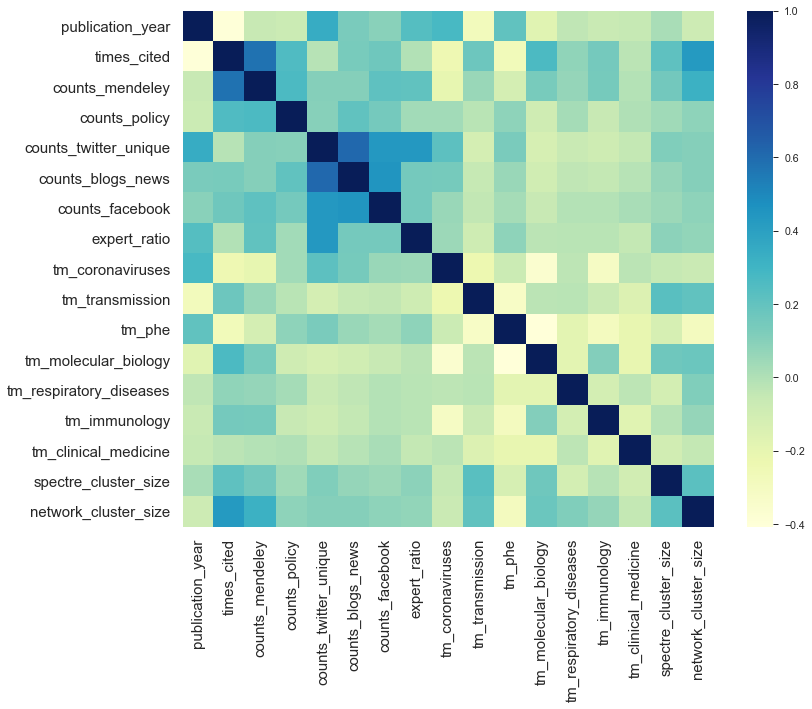

In [257]:
plt.figure(figsize=(12,10))
sns.heatmap(df_reg[["publication_year","times_cited","counts_mendeley","counts_policy","counts_twitter_unique",
                                 "counts_blogs_news","counts_facebook","expert_ratio",
                  "top_j",'tm_coronaviruses', 'tm_transmission', 'tm_phe', 'tm_molecular_biology',
       'tm_respiratory_diseases', 'tm_immunology', 'tm_clinical_medicine',"spectre_cluster_size",
                "network_cluster_size"]].corr(),cmap="YlGnBu")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig("figures/nb5_corr_heat.pdf")

In [258]:
import statsmodels.api as sm
from statsmodels.formula.api import logit

In [287]:
from_when = 2000
to_when = 2020
postedon_when = to_when

test_mod = logit("in_wikipedia ~ C(publication_year, Treatment(%d)) + times_cited + counts_mendeley + counts_policy"
                   "+ counts_twitter_unique + counts_blogs_news + counts_facebook + expert_ratio"
                  "+ C(top_j, Treatment('OTHER')) + tm_coronaviruses + tm_phe + tm_transmission"
                   "+ tm_molecular_biology + tm_respiratory_diseases + tm_immunology"
                   "+ tm_clinical_medicine + spectre_cluster_size "
                "+ network_cluster_size"
                 ""%to_when, df_reg[(df_reg.publication_year>=from_when)&(df_reg.publication_year<=to_when)&((df_reg.posted_on_year<=postedon_when)|(df_reg.in_wikipedia==False))], missing='drop').fit()

# + C(spectre_cluster_id, Treatment) + + C(top_nc, Treatment('OTHER'))

Optimization terminated successfully.
         Current function value: 0.115806
         Iterations 22


In [288]:
print(test_mod.summary())

                           Logit Regression Results                           
Dep. Variable:           in_wikipedia   No. Observations:                57757
Model:                          Logit   Df Residuals:                    57700
Method:                           MLE   Df Model:                           56
Date:                Sat, 09 May 2020   Pseudo R-squ.:                  0.2613
Time:                        16:56:07   Log-Likelihood:                -6688.6
converged:                       True   LL-Null:                       -9054.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                         -9.6121      1.563     -6.151      0.000

In [289]:
test_mod.pred_table()

array([[55501.,   146.],
       [ 1886.,   224.]])

In [290]:
mfx = test_mod.get_margeff()
print(mfx.summary())

        Logit Marginal Effects       
Dep. Variable:           in_wikipedia
Method:                          dydx
At:                           overall
                                                                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
C(publication_year, Treatment(2020))[T.2000.0]                    -0.0244      0.013     -1.930      0.054      -0.049       0.000
C(publication_year, Treatment(2020))[T.2001.0]                    -0.0295      0.011     -2.751      0.006      -0.051      -0.008
C(publication_year, Treatment(2020))[T.2002.0]                    -0.0269      0.011     -2.538      0.011      -0.048      -0.006
C(publication_year, Treatment(2020))[T.2003.0]                    -0.0241      0.006     -3.723      0.000      -0.037      -0.011
C(publication_year, Treatment(2020))[T.2004.0]                

In [291]:
#print(mfx.summary().as_latex())

In [276]:
import statsmodels.formula.api as smf

# Fit and summarize OLS model
ols_mod = smf.ols("counts_wikipedia ~ C(publication_year, Treatment(%d)) + times_cited + counts_mendeley + counts_policy"
                   "+ counts_twitter_unique + counts_blogs_news + counts_facebook + expert_ratio"
                  "+ C(top_j, Treatment('OTHER')) + tm_coronaviruses + tm_phe + tm_transmission"
                   "+ tm_molecular_biology + tm_respiratory_diseases + tm_immunology"
                   "+ tm_clinical_medicine + spectre_cluster_size "
                "+ network_cluster_size"
                 ""%to_when, df_reg[(df_reg.publication_year>=from_when)&(df_reg.publication_year<=to_when)&((df_reg.posted_on_year<=postedon_when)|(df_reg.in_wikipedia==False))], missing='drop').fit()

In [281]:
#print(ols_mod.summary().as_latex())

In [278]:
print(ols_mod.summary())

                            OLS Regression Results                            
Dep. Variable:       counts_wikipedia   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     164.8
Date:                Sat, 09 May 2020   Prob (F-statistic):               0.00
Time:                        16:45:26   Log-Likelihood:                 23722.
No. Observations:               57757   AIC:                        -4.733e+04
Df Residuals:                   57700   BIC:                        -4.682e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

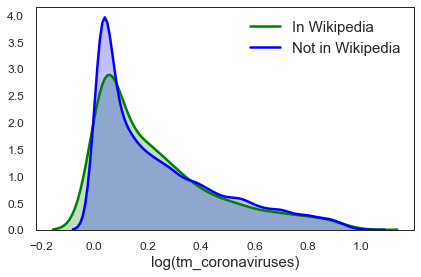

In [270]:
what_to_plot = "tm_coronaviruses"
#plt.figure(figsize=(10,8))
sns.distplot(df_reg[(df_reg.in_wikipedia==1) & (df_reg[what_to_plot]>0)][what_to_plot].values, color="green", kde=True, norm_hist=True, kde_kws={"shade": True}, hist=False, label="In Wikipedia")
sns.distplot(df_reg[(df_reg.in_wikipedia==0) & (df_reg[what_to_plot]>0)][what_to_plot].values, color="blue", kde=True, norm_hist=True, kde_kws={"shade": True}, hist=False, label="Not in Wikipedia")
plt.legend(fontsize=15)
plt.xlabel("log(%s)"%what_to_plot,fontsize=15)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/nb5_%s_in_wiki.pdf"%what_to_plot)